In [2]:
# ブロック1-2-1
import torch  # PyTorchの基本的な機能を含むメインのライブラリ
import torch.nn as nn  # ニューラルネットワークの構築に関連するクラスや関数を含むモジュール
import torch.optim as optim  # 最適化アルゴリズムを含むモジュール
import torchvision  # 一般的なデータセットや事前学習モデルなど、コンピュータビジョンに関するユーティリティを提供
import torchvision.transforms as transforms  # 画像の前処理に関連するクラスや関数を含むモジュール
from torchvision import models  # 事前学習済みモデルや一般的なモデルアーキテクチャを含むモジュール
from torchvision.datasets import ImageFolder # ディレクトリ構造から画像データセットをロードするためのクラス
from torch.utils.data import DataLoader, random_split  # データセットのローディングや分割に関連するユーティリティ

In [3]:
import pandas as pd

In [4]:
# ブロック2-6
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),         # 画像をランダムに水平反転
    transforms.RandomRotation(10),             # 画像を-10〜10度の範囲でランダムに回転
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # 色のバリエーションをランダムに変更
    transforms.Resize([224,224]),  # 画像のサイズを224x224ピクセルにリサイズ
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
csv_filett = './optdata/Human Action Recognition/traning_set.csv'

In [6]:
import os
import shutil
import csv
import pandas as pd
from torchvision.datasets import ImageFolder
from torchvision import transforms

# パスの設定
dataset_path = './optdata/Human Action Recognition/'
destination_path = './optdata/optdata2/'

# Training_set.csvからファイル名とラベルを読み取る
train_class_data = pd.read_csv(os.path.join(dataset_path, 'Training_set.csv'))

# 各ファイルを正しいディレクトリに移動
for index, row in train_class_data.iterrows():
    # 既存のファイルのパス
    current_file_path = os.path.join(dataset_path, 'train', row['filename'])
    # 正しいディレクトリのパス
    correct_dir_path = os.path.join(destination_path, row['label'])
    # 正しいディレクトリが存在しない場合は作成
    if not os.path.exists(correct_dir_path):
        os.makedirs(correct_dir_path)
    # 画像を正しいディレクトリに移動
    shutil.move(current_file_path, correct_dir_path)

# データセットの読み込み
data_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor()])
dataset = ImageFolder(root=destination_path, transform=data_transforms)


Error: Destination path './optdata/optdata2/sitting/Image_1.jpg' already exists

In [9]:
BATCH_SIZE = 16

In [10]:
dataset_path = "./optdata/optdata2/"  # あなたのデータセットへのパスに変更してください
dataset = ImageFolder(root=dataset_path, transform=data_transforms)

In [11]:
# ブロック 4-2
train_size = int(0.7 * len(dataset))  # 70%を訓練データに
val_size = int(0.15 * len(dataset)) # 15%を検証データに
test_size = len(dataset) - train_size - val_size # 残り15%をテストデータに

# 与えられたサイズに基づいてデータセットをランダムに分割
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader =   DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader =  DataLoader(test_dataset,  shuffle=False)

print(len(train_dataset))
print(len(test_dataset))

8820
1890


In [12]:
#test_dataset = data('/content/Human Action Recognition/test',transform=data_transforms)

In [13]:
# ブロック 5-2
device = torch.device("mps")
device # deviceが何に設定されたかを確認

device(type='mps')

ミニバッチサイズ： 16
チャネル数： 3
画像の高さ： 224
画像の幅　： 224
torch.Size([16, 3, 224, 224])


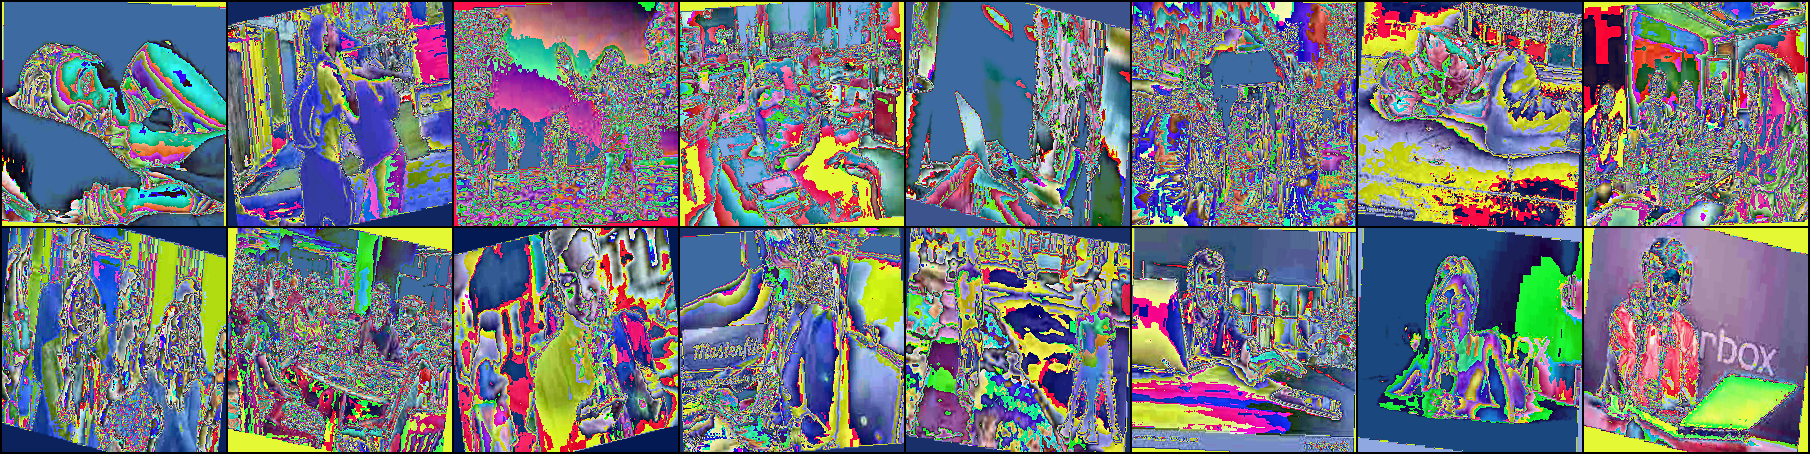

In [14]:
imgs, _ = next(iter(train_loader))
c, h, w = imgs[0].shape
print("ミニバッチサイズ：", len(imgs))
print("チャネル数：", c)
print("画像の高さ：", h)
print("画像の幅　：", w)
print(imgs.shape)

# グリッド上に並べて1枚の画像にする
img = torchvision.utils.make_grid(imgs)
img = transforms.functional.to_pil_image(img)
display(img)

In [15]:
# ブロック 7-1-2
NUM_CLASSES = 15 # 分類するクラス数を設定　0のままではエラー

# ViT base パッチ数16の学習済みモデルを利用
model = models.vit_b_16(weights='DEFAULT')


# 全ての層のパラメータを訓練不可に
for param in model.parameters():
    param.requires_grad = False

# 最後の全結合層をNUM_CLASSES分類用に変更
num_ftrs = model.heads[0].in_features
model.heads[0] = nn.Linear(num_ftrs, NUM_CLASSES)

# GPU上にモデルを移動
model = model.to(device)

# ---------------------------------------------------------
## ViT huge パッチ数14の学習済みモデルを利用
# （注意：入力画像サイズは518x518）
# model = models.vit_h_14(weights='DEFAULT')

## 全ての層のパラメータを訓練不可に
# for param in model.parameters():
#    param.requires_grad = False

## 最後の全結合層をNUM_CLASSES分類用に変更
# num_ftrs = model.heads[0].in_features
# model.heads[0] = nn.Linear(num_ftrs, NUM_CLASSES)
# GPU上にモデルを移動
# model = model.to(device)
# ---------------------------------------------------------

In [16]:
# ブロック 9-1
# モデルのパラメータを更新するためのAdamオプティマイザを初期化し、学習率を0.001に設定する
#optimizer = optim.AdamW(model.parameters(),lr=0.001,weight_decay=5e-4)
optimizer = optim.RMSprop(model.parameters(),lr=0.001,weight_decay=5e-4)

In [17]:
# ブロック 8
# 多クラス分類（2値分類も含む）のための損失関数の使用準備
criterion = nn.CrossEntropyLoss()

Epoch 1/10, Training Loss: 1.0376762649503306, Validation Loss: 0.9440484880900183
Epoch 2/10, Training Loss: 0.7810348575475855, Validation Loss: 0.8786437937191555
Epoch 3/10, Training Loss: 0.7111245756024036, Validation Loss: 0.8692713637812799
Epoch 4/10, Training Loss: 0.6755030339691734, Validation Loss: 0.8848648471992557
Epoch 5/10, Training Loss: 0.6480815221987448, Validation Loss: 0.8864865358136281
Epoch 6/10, Training Loss: 0.6151634141991752, Validation Loss: 0.8704586174307751
Epoch 7/10, Training Loss: 0.6023231495063806, Validation Loss: 0.87790716871494
Epoch 8/10, Training Loss: 0.5863884615482412, Validation Loss: 0.8923872666699546
Epoch 9/10, Training Loss: 0.5779824319255092, Validation Loss: 0.9527488951923466
Epoch 10/10, Training Loss: 0.5723491934114608, Validation Loss: 0.8906485295596243


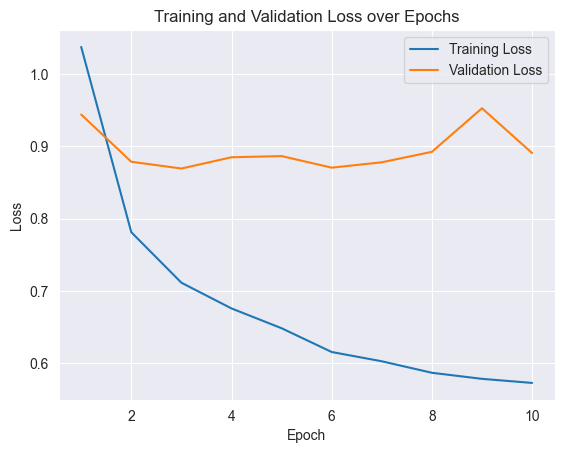

In [18]:
# ブロック 10
# seabornとmatplotlibのライブラリをインポート
import seaborn as sns
import matplotlib.pyplot as plt

train_losses = [] # 訓練時のlossを格納するリスト
val_losses = []   # 検証時のlossを格納するリスト
num_epochs = 10 # 学習回数を20回に設定

# 各エポックでの処理
for epoch in range(num_epochs):
    # モデルを訓練モードに設定
    model.train()
    total_loss = 0.0
    # 訓練データをミニバッチごとに処理
    for i, (images, labels) in enumerate(train_loader):
        # データをGPU等のデバイスに移動
        images, labels = images.to(device), labels.to(device)

        outputs = model(images) # モデルに画像を入力し、予測値を取得
        loss = criterion(outputs, labels) # 損失を計算
        optimizer.zero_grad() # 勾配を初期化
        loss.backward()  # バックプロパゲーションを実行
        optimizer.step() # 重みの更新
        total_loss += loss.item() # 現在のバッチの損失を累積値に追加

    # 平均訓練損失を計算
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # モデルを評価モードに設定
    model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        # 検証データをミニバッチごとに処理
        for images, labels in val_loader:
            # データをGPU等のデバイスに移動
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # モデルに画像を入力し、出力(予測値)を取得
            loss = criterion(outputs, labels) # 損失を計算
            total_val_loss += loss.item() # 現在のバッチの損失を累積値に追加

    # 平均検証損失を計算
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # エポックごとの訓練と検証の損失を表示
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

# グラフのスタイルを設定
sns.set_style("darkgrid")
sns.lineplot(x=range(1, num_epochs + 1), y=train_losses, label="Training Loss") # 訓練の損失のグラフを描画
sns.lineplot(x=range(1, num_epochs + 1), y=val_losses, label="Validation Loss") # 検証の損失のグラフを描画
plt.xlabel("Epoch") # x軸のラベルを設定
plt.ylabel("Loss") # y軸のラベルを設定
plt.title("Training and Validation Loss over Epochs") # グラフのタイトルを設定
plt.legend() # 凡例を表示
plt.show() # グラフを表示

In [56]:
# ブロック 11
model.eval()  # モデルを評価モードに設定。これにより、DropoutやBatchNormalizationなどの層が推論モードに切り替わる。

correct = 0  # 正しく分類されたサンプルの数を初期化
total = 0    # テストデータのサンプルの総数を初期化

# 勾配の計算を停止。評価時には勾配計算が不要なため、メモリ効率と速度を向上させる。
with torch.no_grad():
    for inputs, labels in val_loader:  # テストデータローダからミニバッチ単位でデータを取得
        inputs, labels = inputs.to(device), labels.to(device)  # データを現在のデバイス（CPU or GPU）に移動
        outputs = model(inputs)  # モデルを使って入力から出力を予測
        _, predicted = torch.max(outputs.data, 1)  # 各サンプルの最大値のインデックスを取得（予測されたクラスを取得）
        total += labels.size(0)  # ミニバッチのサンプル数をトータルカウントに追加
        correct += (predicted == labels).sum().item()  # 予測が正しい場合のカウントを加算

print(f"Accuracy on test set: {100 * correct / total}%")  # テストセットの正解率を計算して表示

Accuracy on test set: 79.68253968253968%


In [30]:
torch.save(model.state_dict(), 'Weights01/optrusres.pth')